In [1]:
import pandas as pd
import re
import HTMLParser
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import History 
from keras import regularizers
from keras import optimizers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("LabelledData (1).txt",sep=",,,",header=None ,names=['question','type'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
#Data Cleaning
def data_cleaning(df):
    df['type']=df['type'].str.strip()
    html_parser = HTMLParser.HTMLParser()

    # df['question'] = df['question'].apply(lambda x: html_parser.unescape(x))
    # df['question'] = df['question'].apply(lambda x: x.encode('ascii','ignore'))

    # df['question'] = df['question'].apply(lambda x: x.lower())
    # df['question'] = df['question'].apply(lambda x: x.replace(":",' : '))
    # df['question'] = df['question'].apply(lambda x: x.replace("!",'. '))
    df['question'] = df['question'].apply(lambda x: re.sub('[^a-z0-9\s]','',x))
    df['question'] = df['question'].apply(lambda x: "".join(x.strip()))
    # df.append([df[df.type=='when']]*5,ignore_index=True)
    # df.append([df[df.type=='affirmation']]*5,ignore_index=True)
    # df.append([df[df.type=='unknown']]*2,ignore_index=True)
    return df

df=data_cleaning(df)

In [5]:
#Hyper parameters

MAX_NB_WORDS = 16384
MAX_SEQUENCE_LENGTH=24
SPLIT_RATIO=0.2
EMB_DIMENSION=300
BATCH_SIZE=512
EPOCHS=5000
VERBOSE=0

In [7]:
#Preprocessing

def data_preprocessing(df):
    #tokenization
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ')
    tokenizer.fit_on_texts(df['question'].values)

    X = tokenizer.texts_to_sequences(df['question'].values)
    #padding
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    
    #word_index
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    #label encoding
    Y = df['type']
    le.fit(Y)
    Y=le.transform(Y) 
    labels = to_categorical(np.asarray(Y))
    print('Shape of data tensor:', X.shape)
    print('Shape of label tensor:', labels.shape)
    
    #data splitting
    return train_test_split(X, labels, test_size = SPLIT_RATIO)
    

x_train, x_test, y_train, y_test = data_preprocessing(df)

Found 3685 unique tokens.
('Shape of data tensor:', (1483, 24))
('Shape of label tensor:', (1483, 5))


In [8]:
def get_glove_embeddings()
    embeddings_index = {}
    
    # load and create embeddings
    f = open('./glove.42B.300d.txt')
    for line in f:
        #print line
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index
    
embeddings_index=get_glove_embeddings()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [9]:
print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [10]:
def create_embedding_matrix():
    embedding_matrix = np.zeros((len(word_index) + 1, EMB_DIMENSION))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix=create_embedding_matrix()

In [11]:


embedding_layer = Embedding(len(word_index) + 1,
                            EMB_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [12]:
def get_model():
    history = History()
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.4, recurrent_dropout=0.4, activation='relu',kernel_regularizer=regularizers.l2(0.001)))#,activity_regularizer=regularizers.l1(0.01)))

    #model.add(LSTM(256, dropout_U=0.5, dropout_W=0.5, activation='relu', kernel_regularizer=l2_reg))
    model.add(Dense(5,activation='softmax'))#,kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
    rmsprop = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(loss = 'categorical_crossentropy', optimizer=rmsprop,metrics = ['accuracy'])

In [13]:
model=get_model()

history=model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_data=(x_test, y_test))

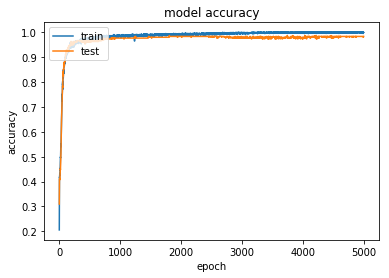

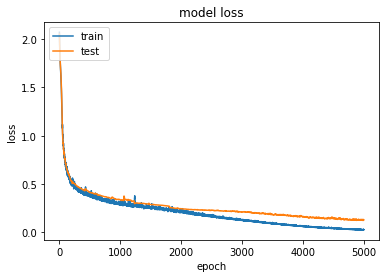

In [14]:
##graphs

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
example = tokenizer.texts_to_sequences(["What time does the train leave"])
example = pad_sequences(example, maxlen=MAX_SEQUENCE_LENGTH)

In [16]:
le.inverse_transform(np.argmax(model.predict(example)))

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'when'

In [17]:
# evaluate the model of test data

from sklearn.metrics import classification_report
predictions = model.predict(x_test)
#print(classification_report(predictions,y_test))
print("Accuracy :",model.evaluate(x_test,y_test))

297/297 [==============================] - 0s 194us/step
('Accuracy :', [0.12871633049238612, 0.9831649831649831])


In [18]:
'''
#Inference

-> deep learning algorithms clearly outperform statistical algorithms
-> LSTMs are better in caputuring sequential features that others cannot.
-> It is more expensive to calculate the network output and apply back propagation in deep learning models.
'''


'\n#Inference\n\n-> deep learning algorithms clearly outperform statistical algorithms\n-> LSTMs are better in caputuring sequential features that others cannot.\n-> It is more expensive to calculate the network output and apply back propagation in deep learning models.\n'